## 初始状态项目结构
```
project
├── code
|   └── e2d_deepfasion.ipynb
└── dataset
    └── deepfasion-multimodel
        ├── images
        ├── test_captions.json
        └── train_captions.json
```

如果不按照此代码框架运行，可能会出问题，或者也可以根据你自己的文件分布，更改`ipynb`代码。

我们首先进行数据集的处理工作。

## 数据集处理方案

数据集下载完成后，我们需要对其进行处理，以适合之后构造的PyTorch数据集类读取。

- 对于文本描述，我们首先构建词典，然后根据词典将文本描述转化为向量。
- 对于图像，我们这里仅记录文件路径。在模型训练与测试阶段，再进行读取。

下面我们开始准备数据集的切片，把训练集切分为训练集、验证集两个部分。

In [7]:
import os
import json
import random
from typing import List, Dict

import torch

code_running_path = os.getcwd()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f"The code is running in path: `{code_running_path}`")
print(f"Device of your machine: {device}: {torch.cuda.get_device_name(0)}")

base_path = "../data/deepfashion_multimodal/"

dataset_path = {
  "images": os.path.join(base_path, "images"),
  "train_label": os.path.join(base_path, "train_captions.json"),
  "test_label": os.path.join(base_path, "test_captions.json")
}


def split_dataset(dataset_path: Dict[str, str]):
    with open(dataset_path["train_label"]) as f:
        train_labels = json.load(f)
    with open(dataset_path["test_label"]) as f:
        test_labels = json.load(f)
    train_labels_name = list(train_labels.keys())
    
    # randomly choose 20% of the training data as validation data
    random.shuffle(train_labels_name)
    val_labels_name = train_labels_name[:int(len(train_labels_name) * 0.2)]
    train_labels_name = train_labels_name[int(len(train_labels_name) * 0.2):]
    test_labels_name = list(test_labels.keys())
    
    # 依据划分的数据集构建 dict
    def make_dataset_dict(image_names: List[str], labels: Dict[str, str]):
        return {k: labels[k] for k in image_names if k in labels.keys()}
    
    train_data_dict = make_dataset_dict(train_labels_name, train_labels)
    val_data_dict = make_dataset_dict(val_labels_name, train_labels)
    test_data_dict = make_dataset_dict(test_labels_name, test_labels)
    
    return train_data_dict, val_data_dict, test_data_dict
    
# split_dataset(dataset_path)

The code is running in path: `/d_workspace/Python/NNDL/code`
Device of your machine: cuda:0: NVIDIA GeForce RTX 4070 Laptop GPU


下面开始整理数据集，按照先前的思路，首先统计每一个单词出现的次数，以此作为后续编码文本的重要依据。

In [8]:
from collections import Counter
from PIL import Image

def encode_vocab(min_word_freq=5):
    output_dir = os.path.join(base_path, 'output')
    
    train_output_path = os.path.join(output_dir, 'train_data.json')
    val_output_path = os.path.join(output_dir, 'val_data.json')
    test_output_path = os.path.join(output_dir, 'test_data.json')
    
    if os.path.exists(output_dir):
        return train_output_path, val_output_path, test_output_path
    else:
        os.mkdir(output_dir)
    
    # first we prepare the vocab
    train_data_dict, val_data_dict, test_data_dict = split_dataset(dataset_path)
    vocab = Counter()
    for _, v in train_data_dict.items():
        tokens = v.split()  # split by whitespace
        tokens = [t.replace('.', '').lower() if '.' in t else t.lower() for t in tokens]
        vocab.update(tokens)
        
        
    words = [w for w, c in vocab.items() if c >= min_word_freq]
    vocab = {w: idx + 1 for idx, w in enumerate(words)} # update the vocab reversely
    
    vocab['<pad>'] = 0
    
    # Note that the operation below will automatically increase the vocab length
    vocab['<unk>'] = len(vocab) 
    vocab['<start>'] = len(vocab)
    vocab['<end>'] = len(vocab)
    with open(os.path.join(output_dir, 'vocab.json'), 'w') as fw:
        json.dump(vocab, fw, indent=4)    # write it into json file
        
        
    # then we encode the captions
    def encode_caption(dataset: Dict[str, str]):
        img_paths = [i_path for i_path in dataset.keys()]
        descrips = [descrip for descrip in dataset.values()]
        
        readable_paths = []
        enc_captions = []
        
        for img_path, descrip in zip(img_paths, descrips):
            # check if the image is OK
            try:
                img_path_ = os.path.join(base_path + 'images/', img_path)
                img = Image.open(img_path_)
            except:
                raise Exception(f"Image `{img_path}` cannot be openned!")
            readable_paths.append(img_path_)
            tokens = descrip.split()
            tokens = [t.replace('.', '').lower() if '.' in t else t.lower() for t in tokens]
            
            enc = [vocab['<start>']] + [vocab.get(t, vocab['<unk>']) for t in tokens] + [vocab['<end>']]
            enc_captions.append(enc)
            
        assert len(readable_paths) == len(enc_captions)
        data = {'IMAGES': readable_paths, 
                'CAPTIONS': enc_captions}
        return data
    
    train_data = encode_caption(train_data_dict)
    with open(os.path.join(output_dir, 'train_data.json'), 'w') as fw:
        json.dump(train_data, fw)
        
    val_data = encode_caption(val_data_dict)
    with open(os.path.join(output_dir, 'val_data.json'), 'w') as fw:
        json.dump(val_data, fw)
        
    test_data = encode_caption(test_data_dict)
    with open(os.path.join(output_dir, 'test_data.json'), 'w') as fw:
        json.dump(test_data, fw)
        
    return train_output_path, val_output_path, test_output_path
        
encode_vocab(min_word_freq=5)

至此我们的项目架构已经变成了：

```
project
├── code
|   └── e2d_deepfasion.ipynb
└── dataset
    └── deepfasion-multimodel
        ├── images (hidden by .gitignore)
        ├── output
        |   ├── test_data.json
        |   ├── train_data.json
        |   ├── val_data.json
        |   └── vocab.json
        |
        ├── test_captions.json
        └── train_captions.json
```

下面对上述数据集处理结果开始进行验证，展示其中一条数据，验证数据的格式是否与我们想象的一致。

<start> this person is wearing a medium-sleeve shirt with graphic patterns the shirt is with cotton fabric it has a round neckline this person wears a three-point shorts the shorts are with leather fabric and pure color patterns the outer clothing is with knitting fabric and solid color patterns this woman wears a ring there is an accessory on her wrist there is an accessory in his her neck <end>
The max length of captions is 92. The avg length is 52.30920728705071


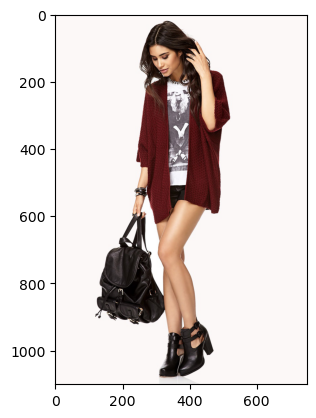

In [9]:
from matplotlib import pyplot as plt

# 读取词典和验证集
with open('../data/deepfashion_multimodal/output/vocab.json', 'r') as f:
    vocab = json.load(f)
vocab_idx2word = {idx:word for word, idx in vocab.items()}

with open('../data/deepfashion_multimodal/output/val_data.json', 'r') as f:
    data = json.load(f)
    
# 展示第14张图片
test_number_index = 14
content_img = Image.open(data['IMAGES'][test_number_index])
plt.imshow(content_img)

print(' '.join([vocab_idx2word[word_idx] for word_idx in data['CAPTIONS'][test_number_index]]))

# 统计最长的caption长度，以及平均长度
max_length = 0
avg_length = 0
for item in data['CAPTIONS']:
    leng = len(item)
    avg_length += leng
    if leng > max_length:
        max_length = leng
        
print(f"The max length of captions is {max_length}. The avg length is {avg_length / len(data['CAPTIONS'])}")

下面我们开始组织训练数据集，使用`torch`中的`dataset`来自定义我们的数据集，便于后续训练使用Dataloader

In [10]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class DeepfashionDataset(Dataset):
    def __init__(self, 
                 dataset_path: str, 
                 vocab_path: str, 
                 dataset_type: str = 'train', 
                 max_len=80, 
                 transform=None):
        """
        @param:
            dataset_path：json格式数据文件路径(全路径)
            vocab_path：json格式词典文件路径
            split：train、val、test
            captions_per_image：每张图片对应的文本描述数
            max_len：文本描述包含的最大单词数
            transform: 图像预处理方法
        """
        self.dataset_type = dataset_type
        assert self.dataset_type in {'train', 'val', 'test'}
        
        with open(dataset_path, 'r') as f:
            self.data: Dict[str, List[str]] = json.load(f)
        with open(vocab_path, 'r') as f:
            self.vocab: Dict[str, int] = json.load(f)
            
        self.max_len = max_len
        self.transform = transform
        self.dataset_size = len(self.data['CAPTIONS'])
        
    def __getitem__(self, index) -> tuple:
        img = Image.open(self.data['IMAGES'][index]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
            
        caplen = len(self.data['CAPTIONS'][index])
        if caplen > self.max_len:
            caption = torch.LongTensor(self.data['CAPTIONS'][index][:self.max_len])
            caplen = self.max_len
        else:
            caption = torch.LongTensor(self.data['CAPTIONS'][index] + [self.vocab['<pad>']] * (self.max_len + 2 - caplen))
            
        return img, caption, caplen
    
    def __len__(self) -> int:
        return self.dataset_size

构建Dataloader

In [11]:
def mktrainval(data_dir, vocab_path, batch_size, workers=4):
    train_tx = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_tx = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    train_set = DeepfashionDataset(os.path.join(data_dir, 'train_data.json'), 
                                 vocab_path, 'train',  transform=train_tx)
    valid_set = DeepfashionDataset(os.path.join(data_dir, 'val_data.json'), 
                                 vocab_path, 'val', transform=val_tx)
    test_set = DeepfashionDataset(os.path.join(data_dir, 'test_data.json'), 
                                 vocab_path, 'test', transform=val_tx)

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    valid_loader = torch.utils.data.DataLoader(
        valid_set, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)
    
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=batch_size, shuffle=False, num_workers=workers, pin_memory=True, drop_last=False)

    return train_loader, valid_loader, test_loader    

### 定义模型
小组计划完成两条路线的模型框架实现：
+ CNN + GRU实现基本的图像生成编解码框架
+ 网格划分表示 + transformer编码器 + 解码器

首先我们实现 `CNN + GRU` 的图像生成编解码框架

In [ ]:
import torch.nn as nn

class ImageEncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(ImageEncoderCNN, self).__init__()
        pass
        
    def forward(self, images):
        pass